# Image Classification - Bring Your Own Container

In [ ]:
import sys
import IPython
!{sys.executable} -m pip install sagemaker-studio-image-build ipywidgets opencv-python matplotlib
IPython.Application.instance().kernel.do_shutdown(True)

In [1]:
import os
import random

import cv2 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

In [24]:
%%sh

# The name of our algorithm 
repository_name=sagemaker-tf-cifar10-latest:latest

cd container/training

sm-docker build . --file ./Dockerfile --repository $repository_name


....[Container] 2022/02/06 05:26:20 Waiting for agent ping

[Container] 2022/02/06 05:26:21 Waiting for DOWNLOAD_SOURCE
[Container] 2022/02/06 05:26:23 Phase is DOWNLOAD_SOURCE
[Container] 2022/02/06 05:26:23 CODEBUILD_SRC_DIR=/codebuild/output/src368158701/src
[Container] 2022/02/06 05:26:23 YAML location is /codebuild/output/src368158701/src/buildspec.yml
[Container] 2022/02/06 05:26:23 Processing environment variables
[Container] 2022/02/06 05:26:23 No runtime version selected in buildspec.
[Container] 2022/02/06 05:26:23 Moving to directory /codebuild/output/src368158701/src
[Container] 2022/02/06 05:26:23 Configuring ssm agent with target id: codebuild:beca6a39-bd59-47df-9725-16cd5c834a70
[Container] 2022/02/06 05:26:23 Successfully updated ssm agent configuration
[Container] 2022/02/06 05:26:23 Registering with agent
[Container] 2022/02/06 05:26:23 Phases found in YAML: 3
[Container] 2022/02/06 05:26:23  BUILD: 4 commands
[Container] 2022/02/06 05:26:23  POST_BUILD: 3 commands
[C

In [2]:
data_folder = '/tmp/data'

train_data_dir = f'{data_folder}/cifar10/train'
test_data_dir = f'{data_folder}/cifar10/test'

In [ ]:
!mkdir -p $data_folder
!aws s3 cp --no-sign-request s3://fast-ai-imageclas/cifar10.tgz $data_folder
!tar -zxvf $data_folder/cifar10.tgz -C $data_folder

In [4]:
class_names = [
    'airplane',
    'automobile', 
    'bird',
    'cat', 
    'deer', 
    'dog', 
    'frog', 
    'horse', 
    'ship', 
    'truck'
]
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (32, 32)

In [5]:
from PIL import Image

def get_image_array(image_path):
    img = Image.open(image_path, 'r')
    return np.array(img)

def display_examples(class_names, dataset_folder):
    fig = plt.figure(figsize = (10, 10))
    fig.suptitle('Some examples of images of the dataset', fontsize = 16)
    
    for i in range(20):
        image_class = class_names[random.randint(0, len(class_names) - 1)]
        image_folder = f'{dataset_folder}/{image_class}'
        image_files = os.listdir(image_folder)
        image_file = image_files[random.randint(0, len(image_files) - 1)]
        image_file_path = f'{image_folder}/{image_file}'
        plt.subplot(4, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(get_image_array(image_file_path))
        plt.xlabel(image_class)
    plt.show()

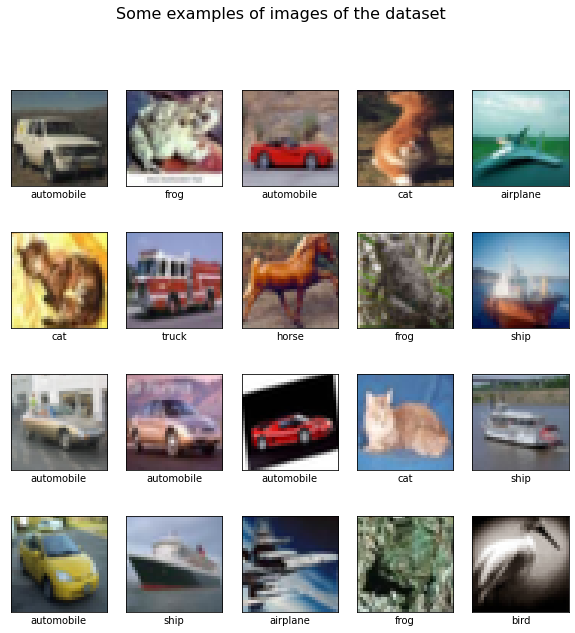

In [6]:
display_examples(class_names, train_data_dir)

In [7]:
import sagemaker
import boto3
from sagemaker import get_execution_role

region = boto3.Session().region_name

session = sagemaker.Session()

bucket = session.default_bucket()


role = get_execution_role()

prefix = "sagemaker/cifar10-byo"

data_path = f"s3://{bucket}/{prefix}/data"
training_data_path = f"{data_path}/training"
validation_data_path = f"{data_path}/validation"

In [9]:
train_data_dir, training_data_path

('/tmp/data/cifar10/train',
 's3://sagemaker-ap-southeast-2-452533547478/sagemaker/cifar10-byo/data/training')

In [8]:
test_data_dir, validation_data_path

('/tmp/data/cifar10/test',
 's3://sagemaker-ap-southeast-2-452533547478/sagemaker/cifar10-byo/data/validation')

## Model Training with SageMaker

In [16]:

client = boto3.client("sts")
account = client.get_caller_identity()["Account"]

my_session = boto3.session.Session()
region = my_session.region_name

algorithm_name = "sagemaker-tf-cifar10-latest"

ecr_image = "{}.dkr.ecr.{}.amazonaws.com/{}:latest".format(account, region, algorithm_name)

print(ecr_image)

452533547478.dkr.ecr.ap-southeast-2.amazonaws.com/sagemaker-tf-cifar10-latest:latest


In [25]:
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput

#Training results: loss=0.97792; accuracy=0.66220; val_loss=0.86919; val_accuracy=0.69960; lr=0.00000
metric_definitions = [
    { "Name": "loss", "Regex": "loss=([0-9\\.]+)"},
    { "Name": "accuracy", "Regex": "accuracy=([0-9\\.]+)" },
    { "Name": "validation:loss", "Regex": "val_loss=([0-9\\.]+)" },
    { "Name": "validation:accuracy", "Regex": "val_accuracy=([0-9\\.]+)" },
]

hyperparameters = {
    "epochs": 20
}

instance_type = "ml.g4dn.xlarge"

estimator = Estimator(
    role=role,
    instance_count=1,
    instance_type=instance_type,
    image_uri=ecr_image,
    hyperparameters=hyperparameters,
    metric_definitions=metric_definitions,
    max_run=30*60
)


In [ ]:

estimator.fit({
    "training": TrainingInput(s3_data=training_data_path, s3_data_type="S3Prefix", input_mode="FastFile"),
    "validation": TrainingInput(s3_data=validation_data_path, s3_data_type="S3Prefix", input_mode="FastFile")
})

2022-02-06 05:30:30 Starting - Starting the training job...
2022-02-06 05:30:53 Starting - Launching requested ML instancesProfilerReport-1644125429: InProgress
...
2022-02-06 05:31:23 Starting - Preparing the instances for training.........
2022-02-06 05:32:56 Downloading - Downloading input data
2022-02-06 05:32:56 Training - Downloading the training image......